## Downloading the data

The Quotebank data can be accessed from the following [link](https://drive.google.com/drive/folders/1R-GVIdxU3jkQb5zU0uG9044Vynh9nYR1?usp=sharing). You can create a shortcut in your Google Drive towards this folder by clicking on the name of folder (Quotebank) and choosing the option "*Add a shortcut to Drive*"
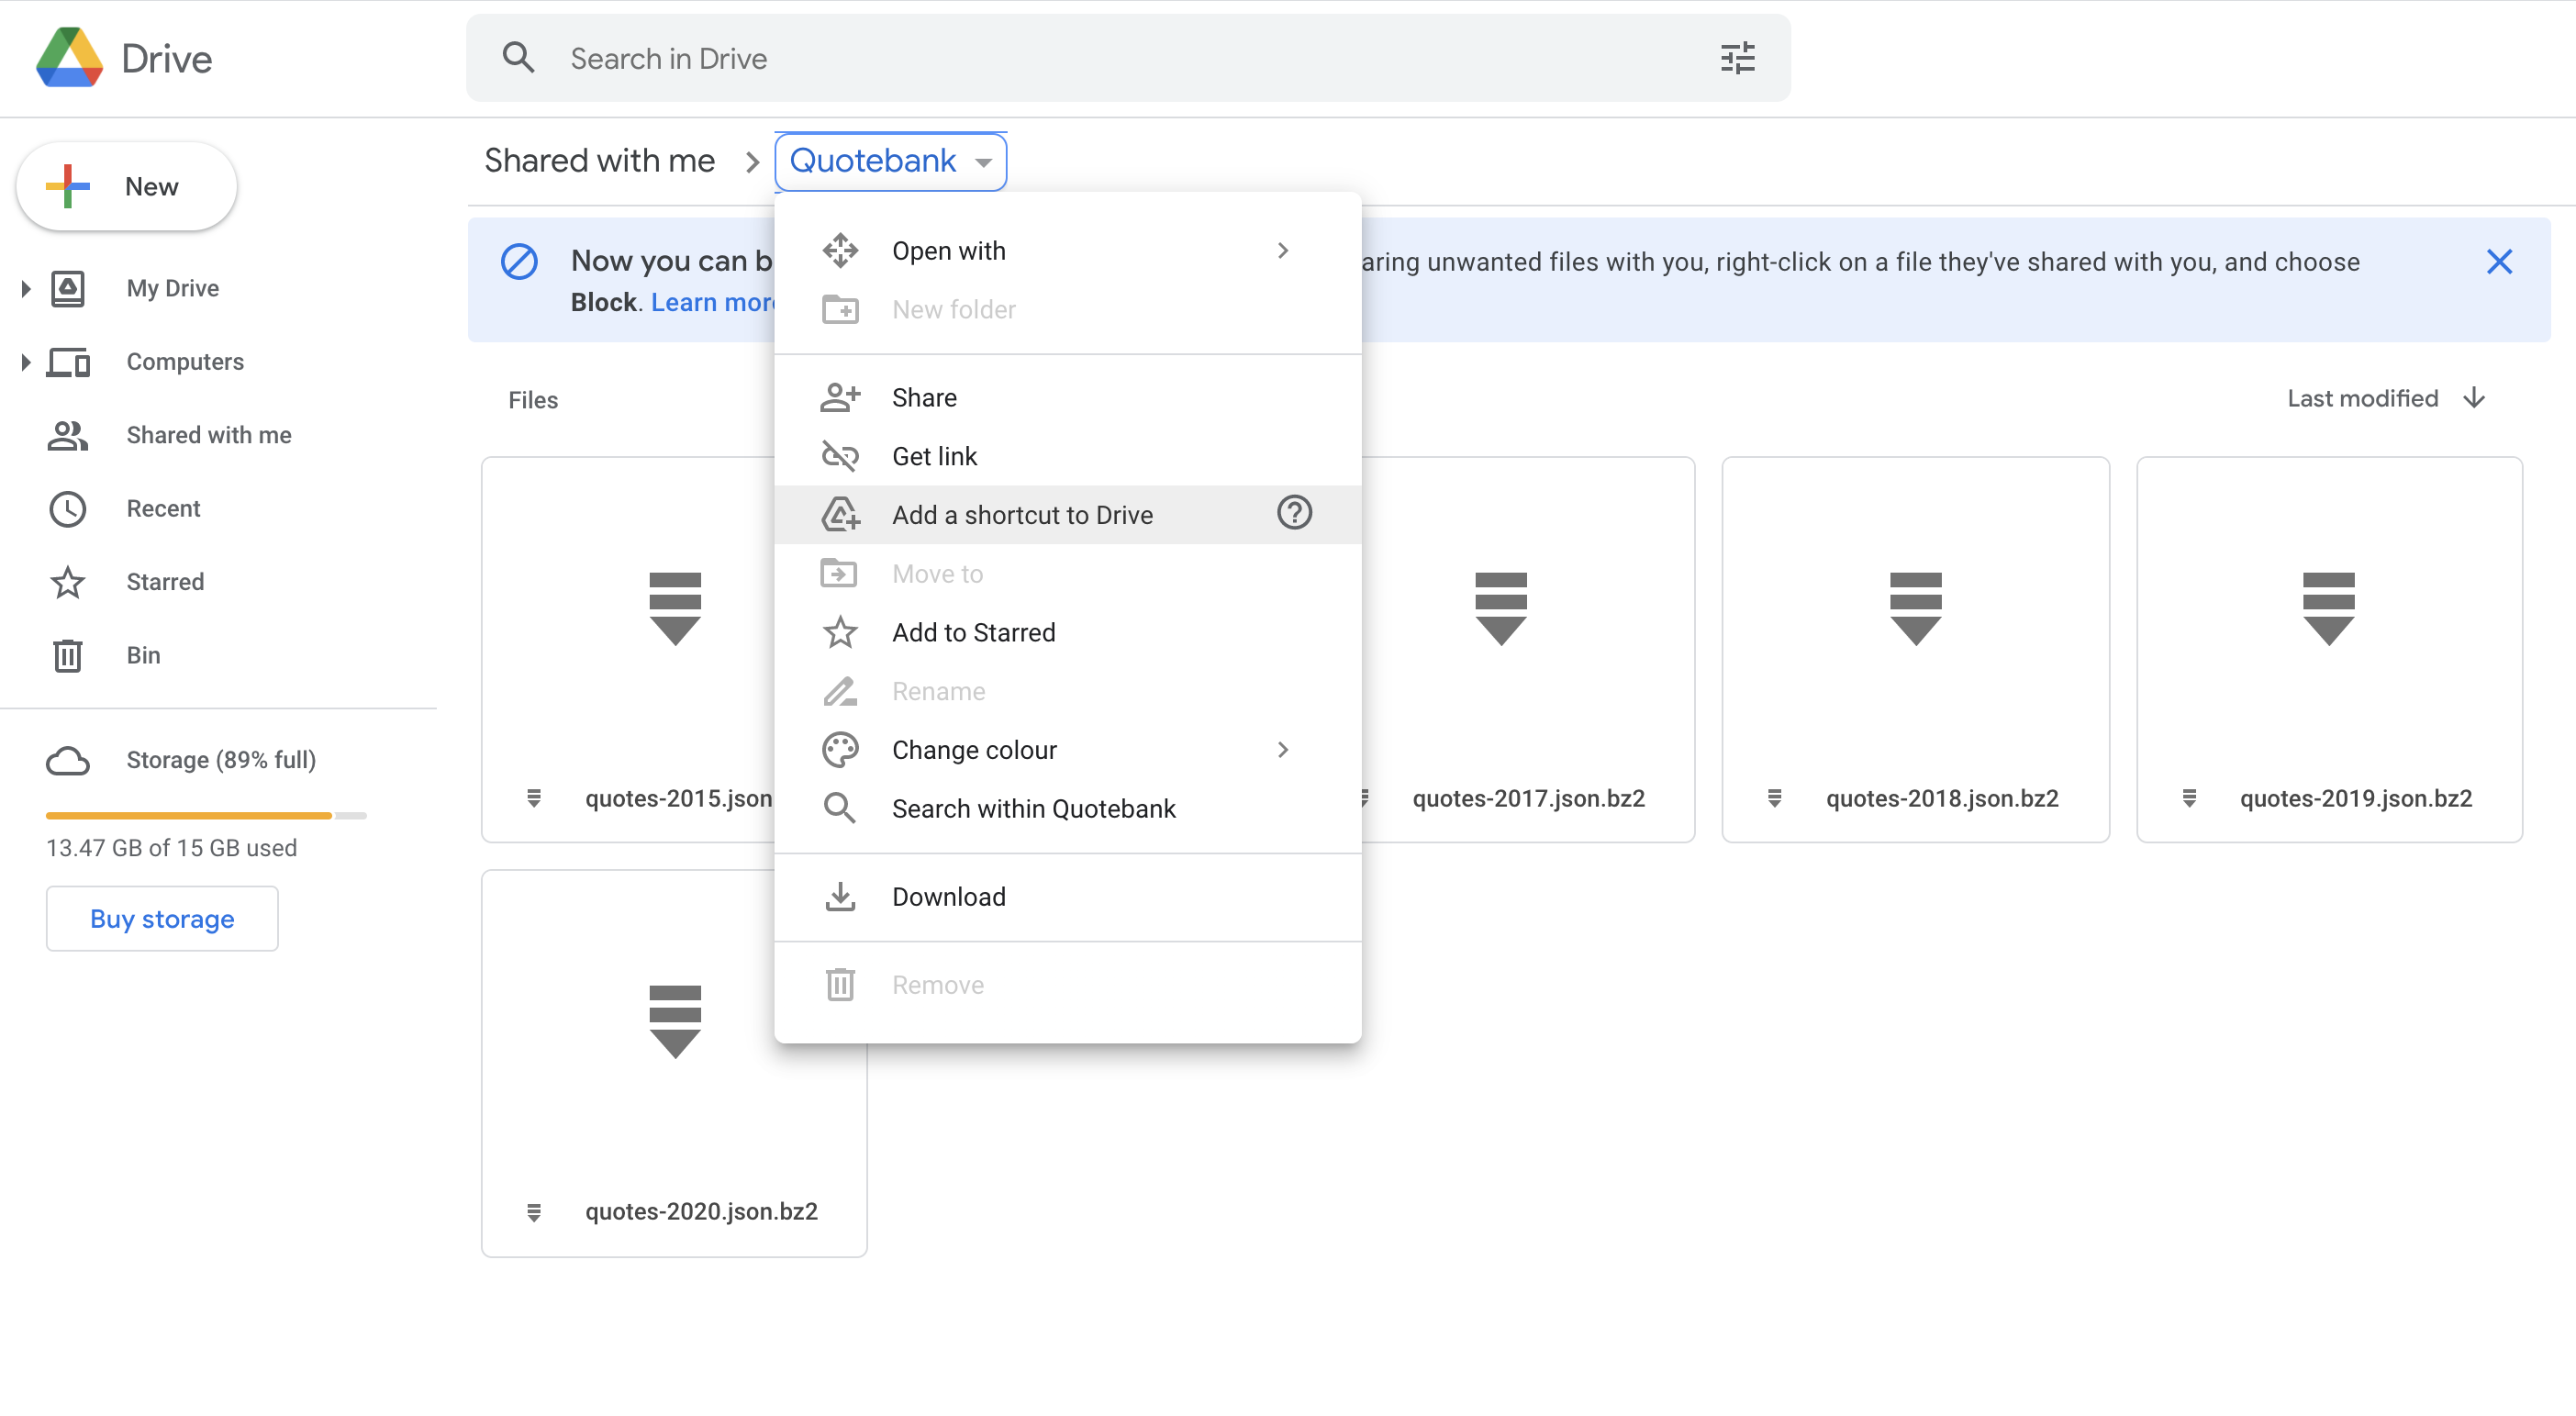

After that, click on ADD SHORTCUT button and the shortcut will be added to your drive. You will be able to access the shortcut from the root My Drive folder.

With your EPFL account you have access to a Google account with unlimited storage Google Drive. To log in, simply use your EPFL email address. This Google account cannot be used to run Colab notebooks but it is possible to run notebooks from one account while mounting a drive from the other one. You can use this drive to store your data (and add a shortcut to the Quotebank data).

## Mouting the Google Drive

It is possible to mount your Google Drive to Colab if you need additional storage or if you need to use files from it. To do that run (click on play button or use keyboard shortcut 'Command/Ctrl+Enter') the following code cell:

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


 

1.   After running the cell, URL will appear.

2.   Following this URL, you will be redirected to the page where you need to choose Google Drive account to mount to.

3.   You will further be asked to give Google Drive Stream a permission to access the chosen Google account

4.   After granting the access, authorization code will be given to you

5.   Copy the authorization code into the dedicated textbox in Colab under '*Enter your authorization code:*' writing

After copying the authorization code, you should get the message saying '*Mounted at /content/gdrive*'

Path to the files from the mounted Drive will then be '/content/drive/MyDrive/'. By opening the Files tab (left sidebar, folder icon) you should also be able to see the accessible files.

## Installs

In [ ]:
!pip install pytrends
!pip install nltk
!pip install tld
!pip install pyarrow
!pip install qwikidata
!pip install transformers

## Imports

In [5]:
import bz2
import json
import nltk
import torch
import pyarrow
import os.path
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as f
from tld import get_tld
from itertools import chain
from google.colab import drive
from collections import Counter
from nltk.corpus import stopwords
from pytrends.request import TrendReq
from transformers import BertModel, BertTokenizer
from sklearn.preprocessing import StandardScaler
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api

## Sample task

You can read the data directly from the Google Drive you mounted following the process above. Make sure you mounted the drive to which you saved the shortcut to the Quotebank data. We will go through a simple task with this data - we will extract domain names of URLs for each sample from the year 2020.

### Extracting the domain names

This is an example on how to extract domain names from a sample. To do that, we can use *tld* library.

Following function then gives domain name. It takes as an argument a list of URLs and returns the domain names:

In [6]:
def get_domains(urls):
  domains = []
  for url in urls:
    res = get_tld(url, as_object=True)
    domains.append(res.tld)
  return domains

Now we will have to read the data. Each sample has property 'urls' which contains a list of links to the original articles containing the quotation. We will extract domain names for these links. Then, we will save a new file that contains samples with extracted domains. The new file will be saved in local storage in Colab but you can change path_to_out variable (optionally) if you want to save it directly to the drive. To generate a new file, run this cell:

In [7]:
# import bz2
# import json

# path_to_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 
# path_to_out = '/content/quotes-2020-domains.json.bz2'

# with bz2.open(path_to_file, 'rb') as s_file:
#     with bz2.open(path_to_out, 'wb') as d_file:
#         for instance in s_file:
#             instance = json.loads(instance) # loading a sample
#             urls = instance['urls'] # extracting list of links
#             domains = get_domains(urls)
#             instance['domains'] = domains # updating the sample with domain name
#             d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

It should take around 25min for this cell to finish running and you will be able to see a file (*quotes-2020-domains.json.bz2*) in the file explorer on the left side once it is done.

You are all set, good luck! :)

## Constants

In [8]:
# Whether to create a parsed file from the Quotebank dataset.
PARSE_QUOTEBANK = True

# Colorblind-friendly color palette.
COLORS = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']

# A mapping between a year and the file that contains the input of that year.
QUOTES_BY_YEAR = {year: f"/content/drive/MyDrive/politicians-quotes-{year}.json.bz2" for year in range(2015, 2021)}

# Path to parquet file used for Wikidata information
WIKIDATA_PATH = f"/content/drive/MyDrive/Quotebank_Wikidata/speaker_attributes.parquet"

# Wikidata columns that are represented by q codes
WIKIDATA_QCODES_COL = ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']

## Setup

In [9]:
pytrend = TrendReq()
nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Quote Parsing

In [10]:
# A list of politicians of interest.
politicians = ["Barack Obama", "George W. Bush", "Donald Trump", "John McCain",
            "Mitt Romney", "Hillary Clinton", "Benjamin Netanyahu",
            "Narendra Modi", "Joe Biden", "Theresa May", "Boris Johnson"]

In [11]:
def get_politicians_data(year):
  # Given a year, parses the Quotebank data and creates a file containing
  # the quotes of politicians from that year.
  path_to_out = QUOTES_BY_YEAR[year]
  path_to_file = f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'
  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for instance in s_file:
        # Load a sample.
        instance = json.loads(instance)
        if (sum([politician in instance['speaker'] for politician in politicians]) > 0):
          # Write sample to new file.
          d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

In [12]:
# get_politicians_data(2019)

In [13]:
# Store politicians data in DataFrame.
data = pd.read_json(QUOTES_BY_YEAR[2018], lines=True)

In [14]:
trump_quotes = data[data["speaker"].str.contains("Donald Trump")]
trump_quotes.head()

quoteID  ... phase
0  2018-05-08-001245  ...     E
1  2018-09-26-003692  ...     E
3  2018-07-30-004176  ...     E
4  2018-10-30-005630  ...     E
5  2018-04-21-003582  ...     E

[5 rows x 9 columns]

In [15]:
obama_quotes = data[data["speaker"].str.contains("Barack Obama")]
obama_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
21,2018-02-12-035226,I cannot paint.,Barack Obama,[Q76],2018-02-12 13:50:00,2,"[[Barack Obama, 0.8319], [Kehinde Wiley, 0.0904], [None, 0.0709], [Amy Sherald, 0.0068]]","[http://www.chicagotribune.com/news/ct-obama-portrait-20180212-story.html, http://www.sentinelsource.com/mcclatchy/obamas-portraits-unveiled/article_17f58b37-0e7c-5827-b619-337bf59051e7.html]",E
34,2018-11-03-029313,"incessant, non-stop attempts to divide us with rhetoric that is designed to make us angry and make us fearful... to pit us against one another, to try to make us believe that things would be better if it just weren't for those who don't look like us, or don't pray for us, or don't love like us.",Barack Obama,[Q76],2018-11-03 01:43:21,3,"[[Barack Obama, 0.7987], [None, 0.164], [Donald Trump, 0.0312], [President Trump, 0.0061]]","[http://thehill.com/homenews/news/414678-obama-accuses-trump-of-political-stunt-one-border-politics, https://www.vanityfair.com/news/2018/11/barack-obama-2018-midterms-florida-georgia-campaign-trail, http://yalibnan.com/2018/11/05/obama-to-trump-supporters-why-are-you-so-mad/]",E
96,2018-10-22-004462,"All right? I believe in a fact-based reality. And, a fact-based politics. I don't believe in just making stuff up.",President Barack Obama,[Q76],2018-10-22 21:36:28,1,"[[President Barack Obama, 0.7669], [None, 0.2133], [Donald Trump, 0.0198]]",[http://www.rawstory.com/2018/10/dont-believe-just-making-stuff-watch-obama-slam-trumps-conspiracy-theories-without-mentioning-name/],E
156,2018-10-26-096425,"The biggest threat to our democracy is cynicism that says, `We're just gon na stay home because my vote doesn't matter, '",President Barack Obama,[Q76],2018-10-26 19:37:30,3,"[[President Barack Obama, 0.8994], [None, 0.0858], [President Trump, 0.0148]]","[http://cbsnews.com/news/live-stream-obama-rally-for-democrats-in-wisconsin-days-after-trump-rally-2018-10-26/, http://feeds.cbsnews.com/~r/primary_source/~3/N_7aUJdCkSU/, http://feeds.cbsnews.com/~r/CBSNewsPolitics/~3/N_7aUJdCkSU/]",E
179,2018-11-14-125138,"was the day I was getting my hair and makeup done,",Barack Obama,[Q76],2018-11-14 16:01:00,1,"[[Barack Obama, 0.7869], [None, 0.2131]]",[http://www.wmagazine.com/story/michelle-obama-2-dope-queens],E


## Quotes and Google Trends

In [16]:
def plot_trend(all_quotes, keyword, year):
  # Get quotes stats from Quotebank.
  df_quotes = all_quotes[all_quotes["quotation"].str.contains(keyword)]
  df_quotes = df_quotes.groupby(by=df_quotes['date'].dt.date)
  quotes_occ = pd.DataFrame(df_quotes['numOccurrences'].sum(),
                           columns=['numOccurrences'])

  # Scale trend.
  quotes_occ["numOccurrences"] = StandardScaler().fit_transform(
    quotes_occ[["numOccurrences"]]
  )

  # Get Google Trends data.
  pytrend.build_payload(kw_list=[keyword], geo='US',
                        timeframe=f'{year}-01-01 {year}-12-31')
  df_google = pytrend.interest_over_time()

  # Scale trend.
  df_google[keyword] = StandardScaler().fit_transform(df_google[[keyword]])

  # Plot trends.
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.plot(quotes_occ, label='Politician quote trend')
  df_google.plot(y=keyword, use_index=True, ax=ax, label='Google trend')
  
  ax.set_title(f'Quotes & Search Trend for "{keyword}"')
  ax.set_xlabel('Date')
  ax.set_ylabel('Trend')
  ax.legend()

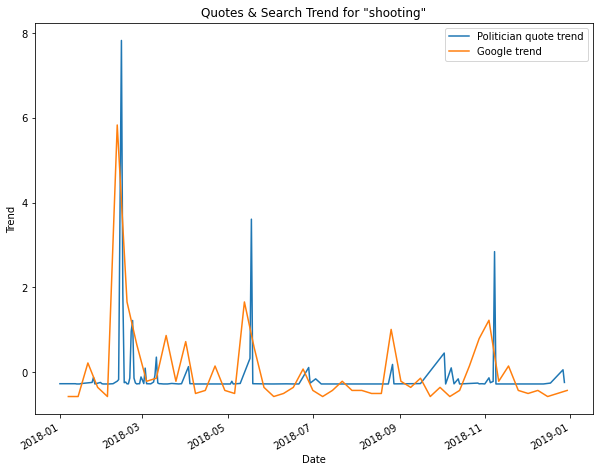

In [17]:
plot_trend(trump_quotes, 'shooting', 2018)

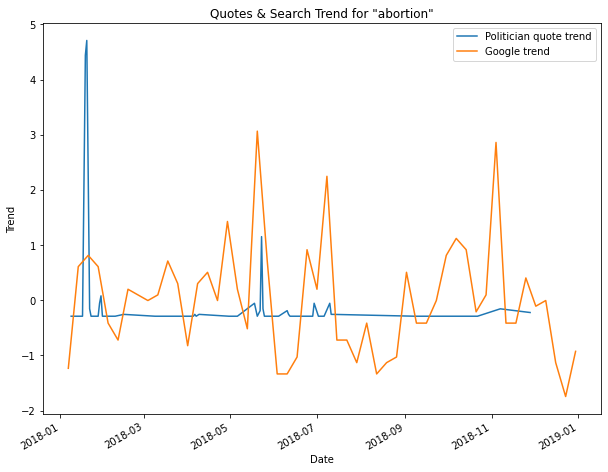

In [18]:
plot_trend(trump_quotes, 'abortion', 2018)

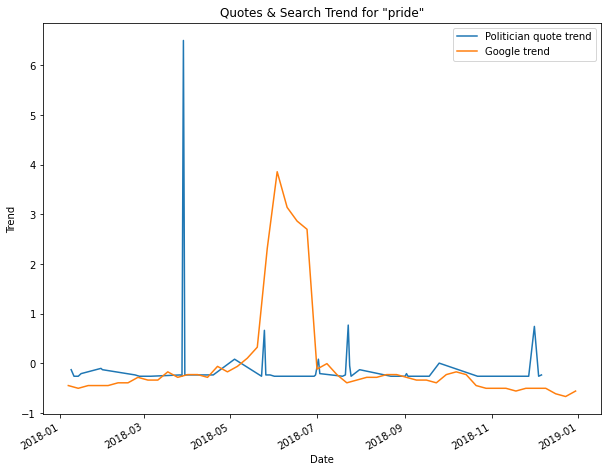

In [19]:
plot_trend(trump_quotes, 'pride', 2018)

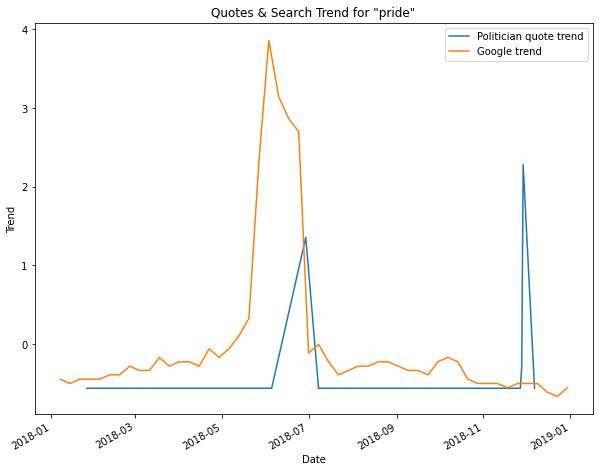

In [20]:
plot_trend(obama_quotes, 'pride', 2018)

## Most common words

In [21]:
# Count most common words.
words_cnt = Counter(" ".join(trump_quotes["quotation"].str.lower()).split()).most_common(100)
filtered_words = [(word, cnt) for word, cnt in words_cnt if word not in stopwords.words('english')]
filtered_words

[('going', 13005),
 ('--', 11040),
 ('people', 11033),
 ('think', 9870),
 ('would', 8700),
 ("we're", 8508),
 ('want', 8096),
 ('like', 7948),
 ('great', 7497),
 ('get', 7152),
 ('know', 5985),
 ('[', 5599),
 ("i'm", 5575),
 ('one', 5534),
 ("that's", 5440),
 ('president', 5247),
 ('us', 5050),
 ('lot', 4923),
 ('good', 4816),
 ('united', 4786),
 ('really', 4759),
 ('many', 4750),
 ('make', 4702),
 (']', 4641),
 ("they're", 4578),
 ('trump', 4571),
 ("he's", 4352),
 ('see', 4268),
 ('never', 4128),
 ('go', 4006),
 ('it.', 3977),
 ('country', 3888),
 ('much', 3887)]

In [22]:
# Count most common words.
words_cnt = Counter(" ".join(obama_quotes["quotation"].str.lower()).split()).most_common(100)
filtered_words = [(word, cnt) for word, cnt in words_cnt if word not in stopwords.words('english')]
filtered_words

[('people', 1306),
 ('--', 1290),
 ('us', 957),
 ('like', 822),
 ('get', 721),
 ("that's", 714),
 ('one', 675),
 ('going', 675),
 ("i'm", 608),
 ('make', 577),
 ('would', 570),
 ('think', 568),
 ('[', 501),
 ('want', 487),
 ('know', 470),
 (']', 447),
 ("we're", 435),
 ('time', 425),
 ("they're", 420),
 ('every', 404),
 ('right', 403),
 ('got', 399),
 ('way', 386),
 ('even', 384),
 ('see', 374),
 ('good', 368),
 ('president', 368),
 ('could', 359),
 ('say', 350)]

In [23]:
obama_quotes[obama_quotes["quotation"].str.contains('gay')]['quotation'].head()

2682                                                                                                                                                                                             the scene of an uprising against police repression that led to a key turning point in the struggle for the civil rights of lesbian, gay, bisexual, and transgender (LGBT) Americans.
17756                                                                                                                                                                                        (W) hen I hear people say they don't like identity politics, I think it's important to remember that identity politics doesn't just apply when it's black people or gay people or women,
28033    I still have to stand here at a lecture and devote some time to saying that black people and white people and Asian people and Latin American people and women and men and gays and straights... are all human, that our differences are superficia

In [24]:
obama_quotes[obama_quotes["quotation"].str.contains('gay') & obama_quotes["quotation"].str.contains('black')]['quotation'].head()

17756                                                                                                                                                                                                (W) hen I hear people say they don't like identity politics, I think it's important to remember that identity politics doesn't just apply when it's black people or gay people or women,
28033            I still have to stand here at a lecture and devote some time to saying that black people and white people and Asian people and Latin American people and women and men and gays and straights... are all human, that our differences are superficial, and that we should treat each other with care and respect. I would have thought we would have figured that out by now.
33060                                                                                                                                                                         Which is why, by the way, when I hear people say they don't li

In [25]:
trump_quotes[trump_quotes["quotation"].str.contains('gay')]['quotation'].head()

1660                                                                                                                                                                                                                                                                                                                                                                                                                                                                       I cannot vibe with gays
3667                                                                                                                       On the surface it may seem like Trump is giving a speech to one of our nation's most beloved icons -- the American farmer. But, the Farm Bureau actually represents a small, tight-knit clan of wealthy, far-right ideologues who oppose gay marriage and gun-free zones, support racist voter suppression laws, and want to gut social welfare programs like Medicaid.
13736                             

In [26]:
trump_quotes[trump_quotes["quotation"].str.contains('gay') & trump_quotes["quotation"].str.contains('black')]['quotation'].head()

189632    anti-gay, anti-black, anti-Jewish, you name it, everybody that wasn't white,
Name: quotation, dtype: object

## News websites and speakers

### Helpers

In [72]:
def get_domain_names(urls):
  """
  Get a list with all domain names for the urls list given as parameter.
  """
  domains = []
  for url in urls:
    res = get_tld(url, as_object=True)
    domains.append(res.domain)
  return domains

def standardize_speaker_name(x):
  """
  Standardize a speaker name to a common one from the list of politicians.
  """
  plts = np.array(politicians)
  return plts[[p in x for p in plts]][0]

### News websites' preference for a speaker

In [62]:
# Do not alter original data
new_data_domains = data.copy()
# Convert urls into domain names -> this takes 1 minute
new_data_domains['urls'] = new_data_domains['urls'].apply(get_domain_names)

In [79]:
# Standardize speaker names in order to be able to group quotes
new_data_domains['speaker'] = new_data_domains['speaker'].apply(standardize_speaker_name)
new_data_domains.head(10)
# Gather all sites that retreieved a politician's quotes
by_politician = new_data_domains.groupby('speaker')['urls'].agg(lambda x: list(chain.from_iterable(x.values))).reset_index()

In [95]:
# Get number of quotes retrieved by a website, for each politician
politicians_websites = []
for index, row in by_politician.iterrows():
  p_websites = pd.DataFrame(Counter(row['urls']).most_common(5),
                                columns=["Website name", "{}".format(row['speaker'])])
  politicians_websites.append(p_websites)

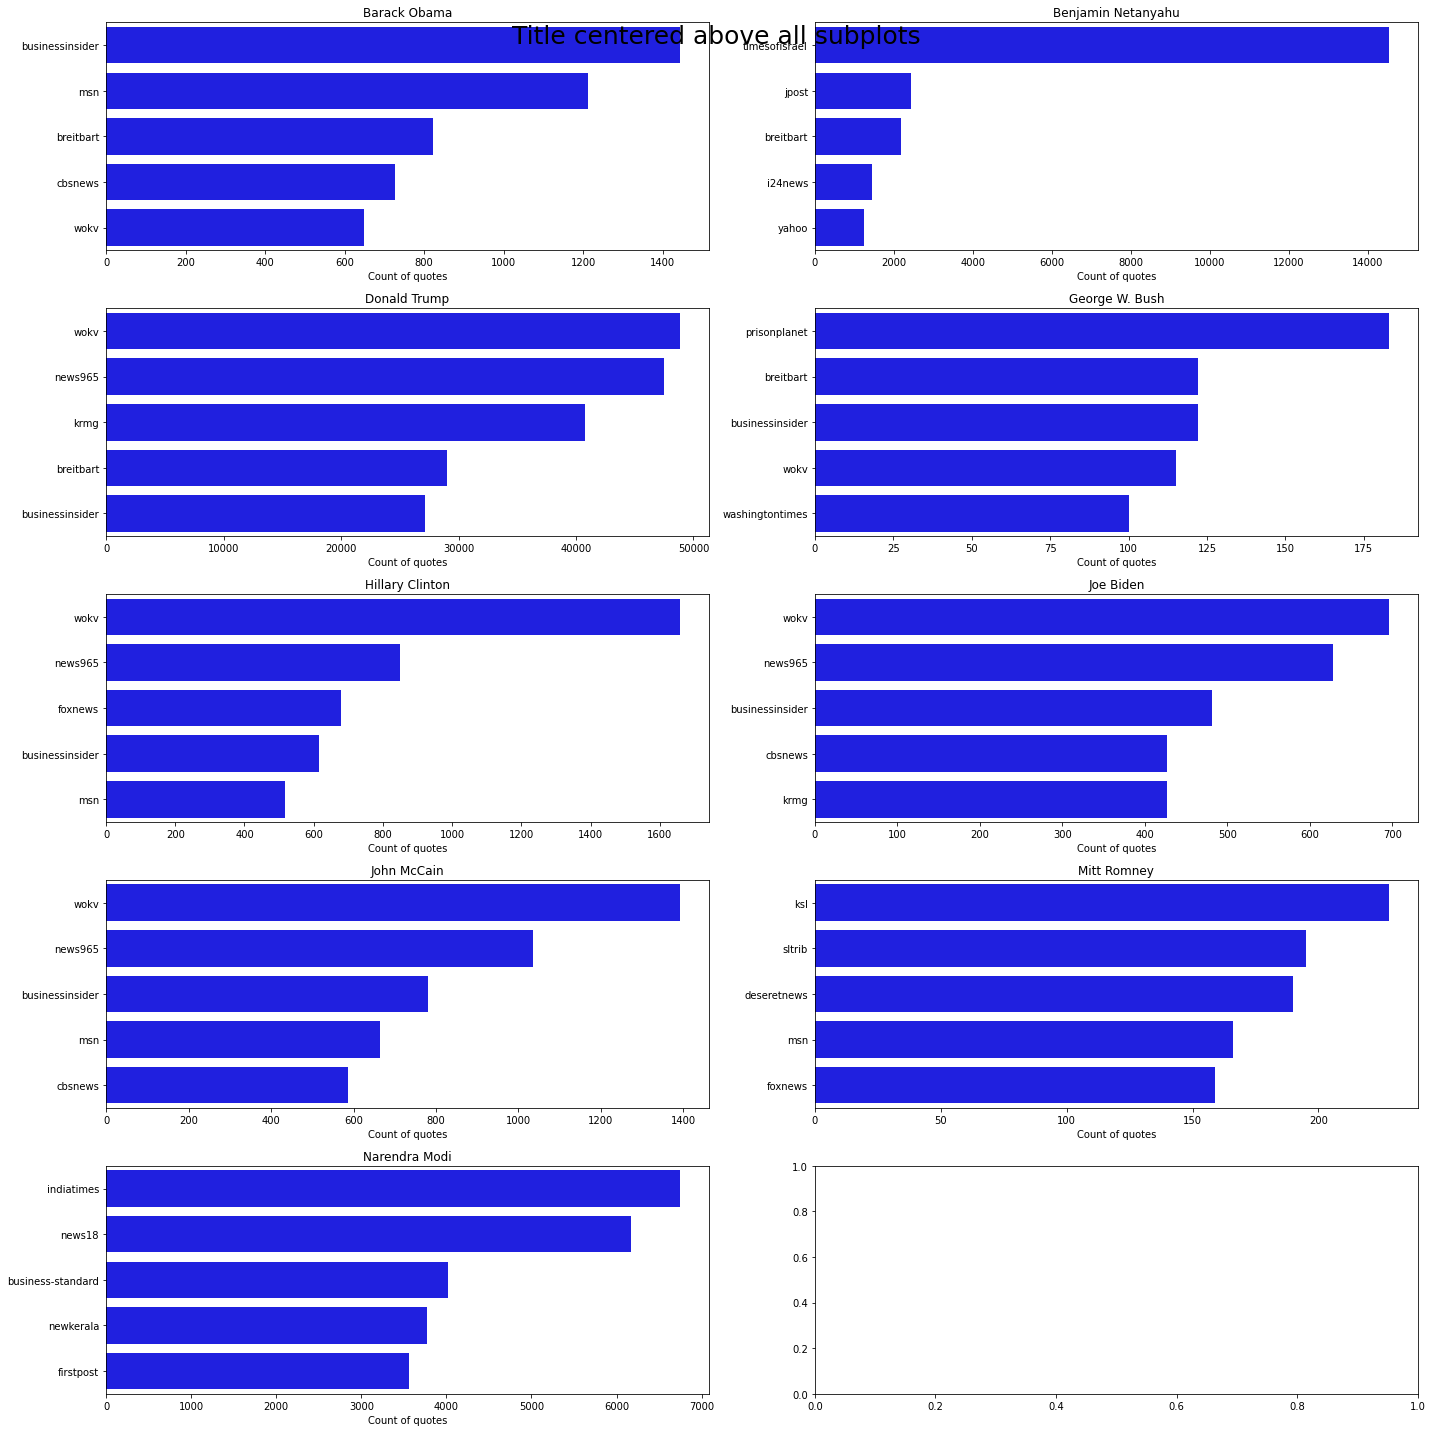

In [120]:
# Plot the websites, preferences for each politician
# TODO: See why title is not showing
w = 2
h = len(politicians_websites) // w + 1
fig, ax = plt.subplots(h, w, figsize=(20, 20))
fig.suptitle("Title centered above all subplots", fontsize=25)
for i in range(h):
  j = 0
  while i * w + j < len(politicians_websites) and j < w:
    sbplt = ax[i, j]
    ax_sns = sns.barplot(x=politicians_websites[j + i * w].columns[-1], y="Website name", 
                         data=politicians_websites[j + i * w], ax=sbplt, color='blue')#.set(xscale="log")
    ax_sns.set(xlabel="Count of quotes", ylabel=None, title=politicians_websites[j + i * w].columns[-1])
    j += 1
fig.tight_layout()

## Wikidata

### Helpers

In [52]:
def convert_qcodes_en(q_codes):
  """
  Function for transforming wikidata q codes into list of english aliases or
  labels related to the specific q code. If list of q_codes is given aggregate
  all the words corresponding to each code. 
  """
  codes_values = []
  if q_codes is not None:
    for q_code in q_codes:
      s = get_entity_dict_from_api(q_code)
      s_value = []
      if len(s.get('aliases', {}).get("en", [])) > 0:
        s_value.extend([v["value"] for v in s['aliases']["en"]])
      if s.get('labels', {}).get("en", {}) != dict():
        s_value.append(s['labels']["en"]["value"])

      codes_values.extend(s_value)
  if len(codes_values) == 0:
    return None

  return codes_values

### Converting Q codes

In [53]:
# Read .parquet file into a dataframe
wikidata = pd.read_parquet(WIKIDATA_PATH, engine='pyarrow')

In [54]:
wikidata.head(1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washington, Father of the United States, The American Fabius]",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, Q81096, Q372436, Q10076267]",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]


In [197]:
# Small test for converting wikidata qcodes into words (just first 5 entries)
# A new file should be created for this, because it takes too long to run it on the entire data every time 
new_wikidata = wikidata.iloc[:5].copy()
for name in WIKIDATA_QCODES_COL:
  new_wikidata[name] = new_wikidata[name].apply(convert_qcodes_en) 


In [198]:
new_wikidata.head(1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washington, Father of the United States, The American Fabius]",[+1732-02-22T00:00:00Z],"[United Kingdom of Great Britain, UK, GB, UKGB, Kingdom of Great Britain, Great Britain, the United States of America, America, U.S.A., USA, U.S., US, the US, the USA, US of A, the United States, U. S. A., U. S., the States, the U.S., 'Merica, U.S, United States, 'Murica, United States of America]","[man, male person, male human, male gender, guy, m, human male, sterner sex, masc, men, boy, boys, ♂, male]",1395141751,None,W000178,"[political leader, political figure, polit., pol, politician, army officer, officer, military official, military officer, agriculturist, grower, raiser, cultivator, agriculturer, farmer (occupation), farmer, mapmaker, map maker, cartographer, surveyor, cartographers and surveyors, land surveyor, engineer, stateswoman, statesman, statesperson, slave holder, slave owner, slave driver, slave master, slaveholder, slave-owner, slaveowner, slaveholder]","[nonpartisan politician, independent member, independent, independent candidate, non-partisan politician, independent politician]",None,Q23,George Washington,"[United States presidential election, 1792, 1792 United States presidential election, 1788 US presidential election, 1788 United States presidential election, 1788-1789 US presidential election, 1788-1789 United States presidential election, 1st US presidential election, United States presidential election, 1788–1789, 1788–89 United States presidential election]",item,"[Gu fakes, Guerra universitaria, Episcopalianism, The Episcopal Church in the United States of America, Episcopal Church]"


### Qids "problem" and dataframes merging 

In [199]:
# Get samples with multiple qids (the maximum number is 2)
samples_with_multiple_qids = data.loc[data['qids'].apply(lambda x: len(x)) > 1]['qids']
# Get the second qid from each sample
samples_with_multiple_qids_1 = samples_with_multiple_qids.apply(lambda x: x[1])
# Check that all second qids are in fact 'Q27947481'
print("All second qids are Q27947481: {}".format(sum(samples_with_multiple_qids_1 == 'Q27947481') == samples_with_multiple_qids.count()))

All second qids are Q27947481: True


In [200]:
# So maybe remove the second qid from each sample, in order to join with wikidata - this needs further investigation

# Do not alter original data
new_data = data.copy()
# Keep only first qid
new_data['qids'] = data['qids'].apply(lambda x: x[0])

In [202]:
# Join the 2 tables - note that new_wikidata has only 5 samples for now
all_data = pd.merge(new_data, new_wikidata.set_index('id'), left_on='qids', right_on='id', how='inner')
all_data.head(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
0,2018-09-01-065477,"We will remember him as he was,",George W. Bush,Q207,2018-09-01 16:14:36,2,"[[George W. Bush, 0.5481], [None, 0.4054], [John McCain, 0.0465]]","[https://mic.com/articles/191026/george-w-bush-on-mccain-his-absence-is-tangible-like-the-silence-after-a-mighty-roar?mic_referral=homepage:featured:6, https://mic.com/articles/191026/george-w-bush-on-mccain-his-absence-is-tangible-like-the-silence-after-a-mighty-roar?mic_referral=homepage:featured:7]",E,"[George Walker Bush, Bush Jr., Dubya, GWB, Bush 43, President George W. Bush, George Bush, President Bush, Bush, Bush, George W.]",[+1946-07-06T00:00:00Z],"[the United States of America, America, U.S.A., USA, U.S., US, the US, the USA, US of A, the United States, U. S. A., U. S., the States, the U.S., 'Merica, U.S, United States, 'Murica, United States of America]","[man, male person, male human, male gender, guy, m, human male, sterner sex, masc, men, boy, boys, ♂, male]",1395142029,None,None,"[political leader, political figure, polit., pol, politician, motivational speaker, autobiographer, painter, rugby union player, army officer, officer, military official, military officer, stateswoman, statesman, statesperson, business person, dealer, businesswoman, business man, business woman, businessman, businessperson, financier]","[GOP, Grand Old Party, Republicans, Republican Party (United States), United States Republican Party, US Republican Party, The Republicans, Republican Party]",None,George W. Bush,"[United States presidential election, 2000, 2000 United States presidential election, United States presidential election of 2004, 2004 US presidential election, US presidential election 2004, 56th US presidential election, United States presidential election, 2004, 2004 United States presidential election, Texas gubernatorial election, 1998, 1998 Texas gubernatorial election, United States House of Representatives elections, 1978, 1978 United States House of Representatives elections]",item,"[UMC, United Methodist Church, Gu fakes, Guerra universitaria, Episcopalianism, The Episcopal Church in the United States of America, Episcopal Church, Methodist movement, Methodist church, Methodists, Methodism]"
1,2018-01-24-164713,You're probably in better condition than other detainees...,George W. Bush,Q207,2018-01-24 11:00:00,1,"[[George W. Bush, 0.7067], [None, 0.2933]]",[http://highline.huffingtonpost.com/articles/en/dark-tourism/],E,"[George Walker Bush, Bush Jr., Dubya, GWB, Bush 43, President George W. Bush, George Bush, President Bush, Bush, Bush, George W.]",[+1946-07-06T00:00:00Z],"[the United States of America, America, U.S.A., USA, U.S., US, the US, the USA, US of A, the United States, U. S. A., U. S., the States, the U.S., 'Merica, U.S, United States, 'Murica, United States of America]","[man, male person, male human, male gender, guy, m, human male, sterner sex, masc, men, boy, boys, ♂, male]",1395142029,None,None,"[political leader, political figure, polit., pol, politician, motivational speaker, autobiographer, painter, rugby union player, army officer, officer, military official, military officer, stateswoman, statesman, statesperson, business person, dealer, businesswoman, business man, business woman, businessman, businessperson, financier]","[GOP, Grand Old Party, Republicans, Republican Party (United States), United States Republican Party, US Republican Party, The Republicans, Republican Party]",None,George W. Bush,"[United States presidential election, 2000, 2000 United States presidential election, United States presidential election of 2004, 2004 US presidential election, US presidential election 2004, 56th US presidential election, United States presidential election, 2004, 2004 United States presidential election, Texas gubernatorial 

## BERT

In [37]:
# Starting something on BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Suggestions

In my opinion we should:

*   Clean quotes - remove punctuation and maybe tokenize them
*   Replace urls with domain names
*   Replace wikidata qcodes with their semnification - create a zip
*   Be sure that only first value in list of qids are useful, then remove the others
*   Merge the wikidata's and quotebank's dataframes by an inner join on id/qids
* Create final zip, by year

Then:

*   Find a similarity formula for quotes, cuz we need one in order to compare quotes - use ...... BERT !
*   Categorize quotes in order to see if websites have a preference for specific types of quotes - use......aah.....also BERT




